In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np
from scipy.stats import spearmanr, kendalltau

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/shreyasc/encoder_111.ckpt"

with initialize(config_path="../../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Load in the test images:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
test_data = []
for batch in test_dl:
    test_data.append(move_data_to_device(batch, device))

Load in encoder weights:

In [5]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Store true and posterior mode shear and convergence for the test images:

In [6]:
shear1_true = torch.zeros(len(test_data), 8, 8, device=device)
shear1_pred = torch.zeros(len(test_data), 8, 8, device=device)
shear1_baseline = torch.zeros(len(test_data), 8, 8, device=device)
shear2_true = torch.zeros(len(test_data), 8, 8, device=device)
shear2_pred = torch.zeros(len(test_data), 8, 8, device=device)
shear2_baseline = torch.zeros(len(test_data), 8, 8, device=device)
convergence_true = torch.zeros(len(test_data), 8, 8, device=device)
convergence_pred = torch.zeros(len(test_data), 8, 8, device=device)
ra = torch.zeros(len(test_data), 8, 8, device=device)
dec = torch.zeros(len(test_data), 8, 8, device=device)

for i in range(len(test_data)):
    shear1_true[i] = test_data[i]['tile_catalog']['shear_1'].squeeze()
    shear2_true[i] = test_data[i]['tile_catalog']['shear_2'].squeeze()
    convergence_true[i] = test_data[i]['tile_catalog']['convergence'].squeeze()
    ra[i] = test_data[i]['tile_catalog']['ra'].squeeze()
    dec[i] = test_data[i]['tile_catalog']['dec'].squeeze()
    
    with torch.no_grad():
        mode_cat = encoder.sample(test_data[i], use_mode=True)
    
    shear1_pred[i] = mode_cat['shear_1'].squeeze()
    shear1_baseline[i] = test_data[i]['tile_catalog']['ellip_lsst_wavg'][...,0].squeeze()
    shear2_pred[i] = mode_cat['shear_2'].squeeze()
    shear2_baseline[i] = test_data[i]['tile_catalog']['ellip_lsst_wavg'][...,1].squeeze()
    convergence_pred[i] = mode_cat['convergence'].squeeze()

Compute test MSEs:

In [7]:
print(f'shear 1 test MSE (BLISS) = {((shear1_true - shear1_pred) ** 2).mean()}')
print(f'shear 1 test MSE (baseline) = {((shear1_true - shear1_baseline) ** 2).mean()}')
print(f'shear 2 test MSE (BLISS) = {((shear2_true - shear2_pred) ** 2).mean()}')
print(f'shear 2 test MSE (baseline) = {((shear2_true - shear2_baseline) ** 2).mean()}')
print(f'convergence test MSE = {((convergence_true - convergence_pred) ** 2).mean()}')

shear 1 test MSE (BLISS) = 5.8496847486821935e-05
shear 1 test MSE (baseline) = 8.457939838990569e-05
shear 2 test MSE (BLISS) = 5.92962205701042e-05
shear 2 test MSE (baseline) = 6.542240589624271e-05
convergence test MSE = 6.544510688399896e-05


Compute Pearson correlation coefficients:

In [8]:
print(f'shear 1 pearson correlation (BLISS) = {np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1,0]}')
print(f'shear 1 pearson correlation (baseline) = {np.corrcoef(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[1,0]}')
print(f'shear 2 pearson correlation (BLISS) = {np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1,0]}')
print(f'shear 2 pearson correlation (baseline) = {np.corrcoef(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[1,0]}')
print(f'convergence pearson correlation = {np.corrcoef(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[1,0]}')

shear 1 pearson correlation (BLISS) = 0.4329497348562301
shear 1 pearson correlation (baseline) = -0.30977829552516634
shear 2 pearson correlation (BLISS) = 0.42015357513717305
shear 2 pearson correlation (baseline) = 0.29289556292895047
convergence pearson correlation = 0.7575299094585781


Compute Spearman correlation coefficients:

In [9]:
print(f'shear 1 spearman correlation (BLISS) = {spearmanr(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 1 spearman correlation (baseline) = {spearmanr(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[0]}')
print(f'shear 2 spearman correlation (BLISS) = {spearmanr(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')
print(f'shear 2 spearman correlation (baseline) = {spearmanr(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[0]}')
print(f'convergence spearman correlation = {spearmanr(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[0]}')

shear 1 spearman correlation (BLISS) = 0.38786726666761867
shear 1 spearman correlation (baseline) = -0.29076165105997476
shear 2 spearman correlation (BLISS) = 0.3660508022771549
shear 2 spearman correlation (baseline) = 0.30555728615681244
convergence spearman correlation = 0.6868097021898616


Compute Kendall correlation coefficients:

In [10]:
print(f'shear 1 kendall correlation (BLISS) = {kendalltau(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 1 kendall correlation (baseline) = {kendalltau(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu())[0]}')
print(f'shear 2 kendall correlation (BLISS) = {kendalltau(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')
print(f'shear 2 kendall correlation (baseline) = {kendalltau(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu())[0]}')
print(f'convergence kendall correlation = {kendalltau(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu())[0]}')

shear 1 kendall correlation (BLISS) = 0.2693259980901024
shear 1 kendall correlation (baseline) = -0.2003736811254396
shear 2 kendall correlation (BLISS) = 0.2536476308394338
shear 2 kendall correlation (baseline) = 0.2053615914419695
convergence kendall correlation = 0.5005520501723705


Compute test loss:

In [11]:
with torch.no_grad():
    print(f'test loss = {np.mean([encoder._compute_loss(test_data[i], None).cpu() for i in range(len(test_data))])}')

/home/twhit/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


test loss = -10.340522766113281


Scatterplots of true vs. posterior mode shear and convergence:

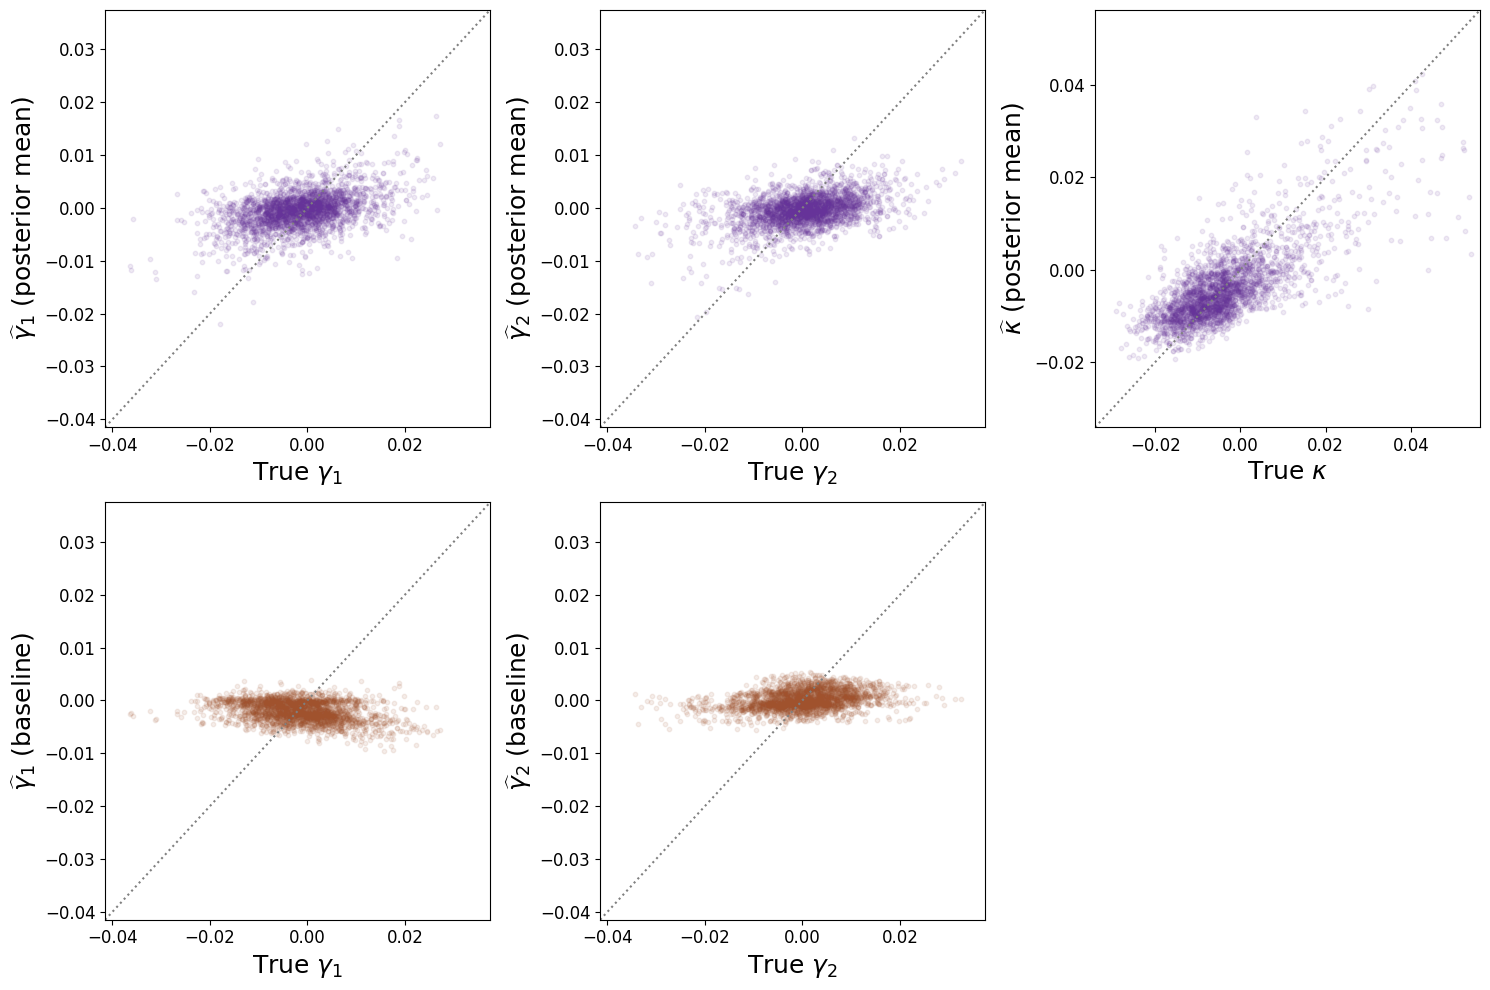

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
alpha = 0.1
s = 10
fontsize = 18
ticklabelsize = 12
bliss_color = 'rebeccapurple'
baseline_color = 'sienna'
shear_min = min(shear1_true.min(), shear2_true.min(), shear1_pred.min(), shear2_pred.min(), shear1_baseline.min(), shear2_baseline.min()).cpu() - 0.005
shear_max = max(shear1_true.max(), shear2_true.max(), shear1_pred.max(), shear2_pred.max(), shear1_baseline.max(), shear2_baseline.max()).cpu() + 0.005
conv_min = min(convergence_true.min(), convergence_pred.min()).cpu() - 0.005
conv_max = max(convergence_true.quantile(0.995), convergence_pred.quantile(0.995)).cpu() + 0.005

_ = ax[0,0].scatter(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s)
_ = ax[0,0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0,0].set_ylabel(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize = fontsize)
_ = ax[0,0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0,0].set_xlim((shear_min, shear_max))
_ = ax[0,0].set_ylim((shear_min, shear_max))
_ = ax[0,0].axline((0,0), slope = 1, linestyle = ':', color = 'gray')

_ = ax[0,1].scatter(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s)
_ = ax[0,1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[0,1].set_ylabel(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize = fontsize)
_ = ax[0,1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0,1].set_xlim((shear_min, shear_max))
_ = ax[0,1].set_ylim((shear_min, shear_max))
_ = ax[0,1].axline((0,0), slope = 1, linestyle = ':', color = 'gray')

_ = ax[0,2].scatter(convergence_true.flatten().cpu(), convergence_pred.flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s)
_ = ax[0,2].set_xlabel(r'True $\kappa$', fontsize = fontsize)
_ = ax[0,2].set_ylabel(r'$\widehat{\kappa}$ (posterior mean)', fontsize = fontsize)
_ = ax[0,2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0,2].set_xlim((conv_min, conv_max))
_ = ax[0,2].set_ylim((conv_min, conv_max))
_ = ax[0,2].axline((0,0), slope = 1, linestyle = ':', color = 'gray')

_ = ax[1,0].scatter(shear1_true.flatten().cpu(), shear1_baseline.flatten().cpu(),
                  color = baseline_color, alpha = alpha, s = s)
_ = ax[1,0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[1,0].set_ylabel(r'$\widehat{\gamma}_1$ (baseline)', fontsize = fontsize)
_ = ax[1,0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1,0].set_xlim((shear_min, shear_max))
_ = ax[1,0].set_ylim((shear_min, shear_max))
_ = ax[1,0].axline((0,0), slope = 1, linestyle = ':', color = 'gray')

_ = ax[1,1].scatter(shear2_true.flatten().cpu(), shear2_baseline.flatten().cpu(),
                  color = baseline_color, alpha = alpha, s = s)
_ = ax[1,1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1,1].set_ylabel(r'$\widehat{\gamma}_2$ (baseline)', fontsize = fontsize)
_ = ax[1,1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1,1].set_xlim((shear_min, shear_max))
_ = ax[1,1].set_ylim((shear_min, shear_max))
_ = ax[1,1].axline((0,0), slope = 1, linestyle = ':', color = 'gray')

_ = ax[1,2].set_xticks([])
_ = ax[1,2].set_yticks([])
for spine in ax[1,2].spines.values():
    spine.set_visible(False)

fig.tight_layout()

fig.savefig("figures/figure4.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

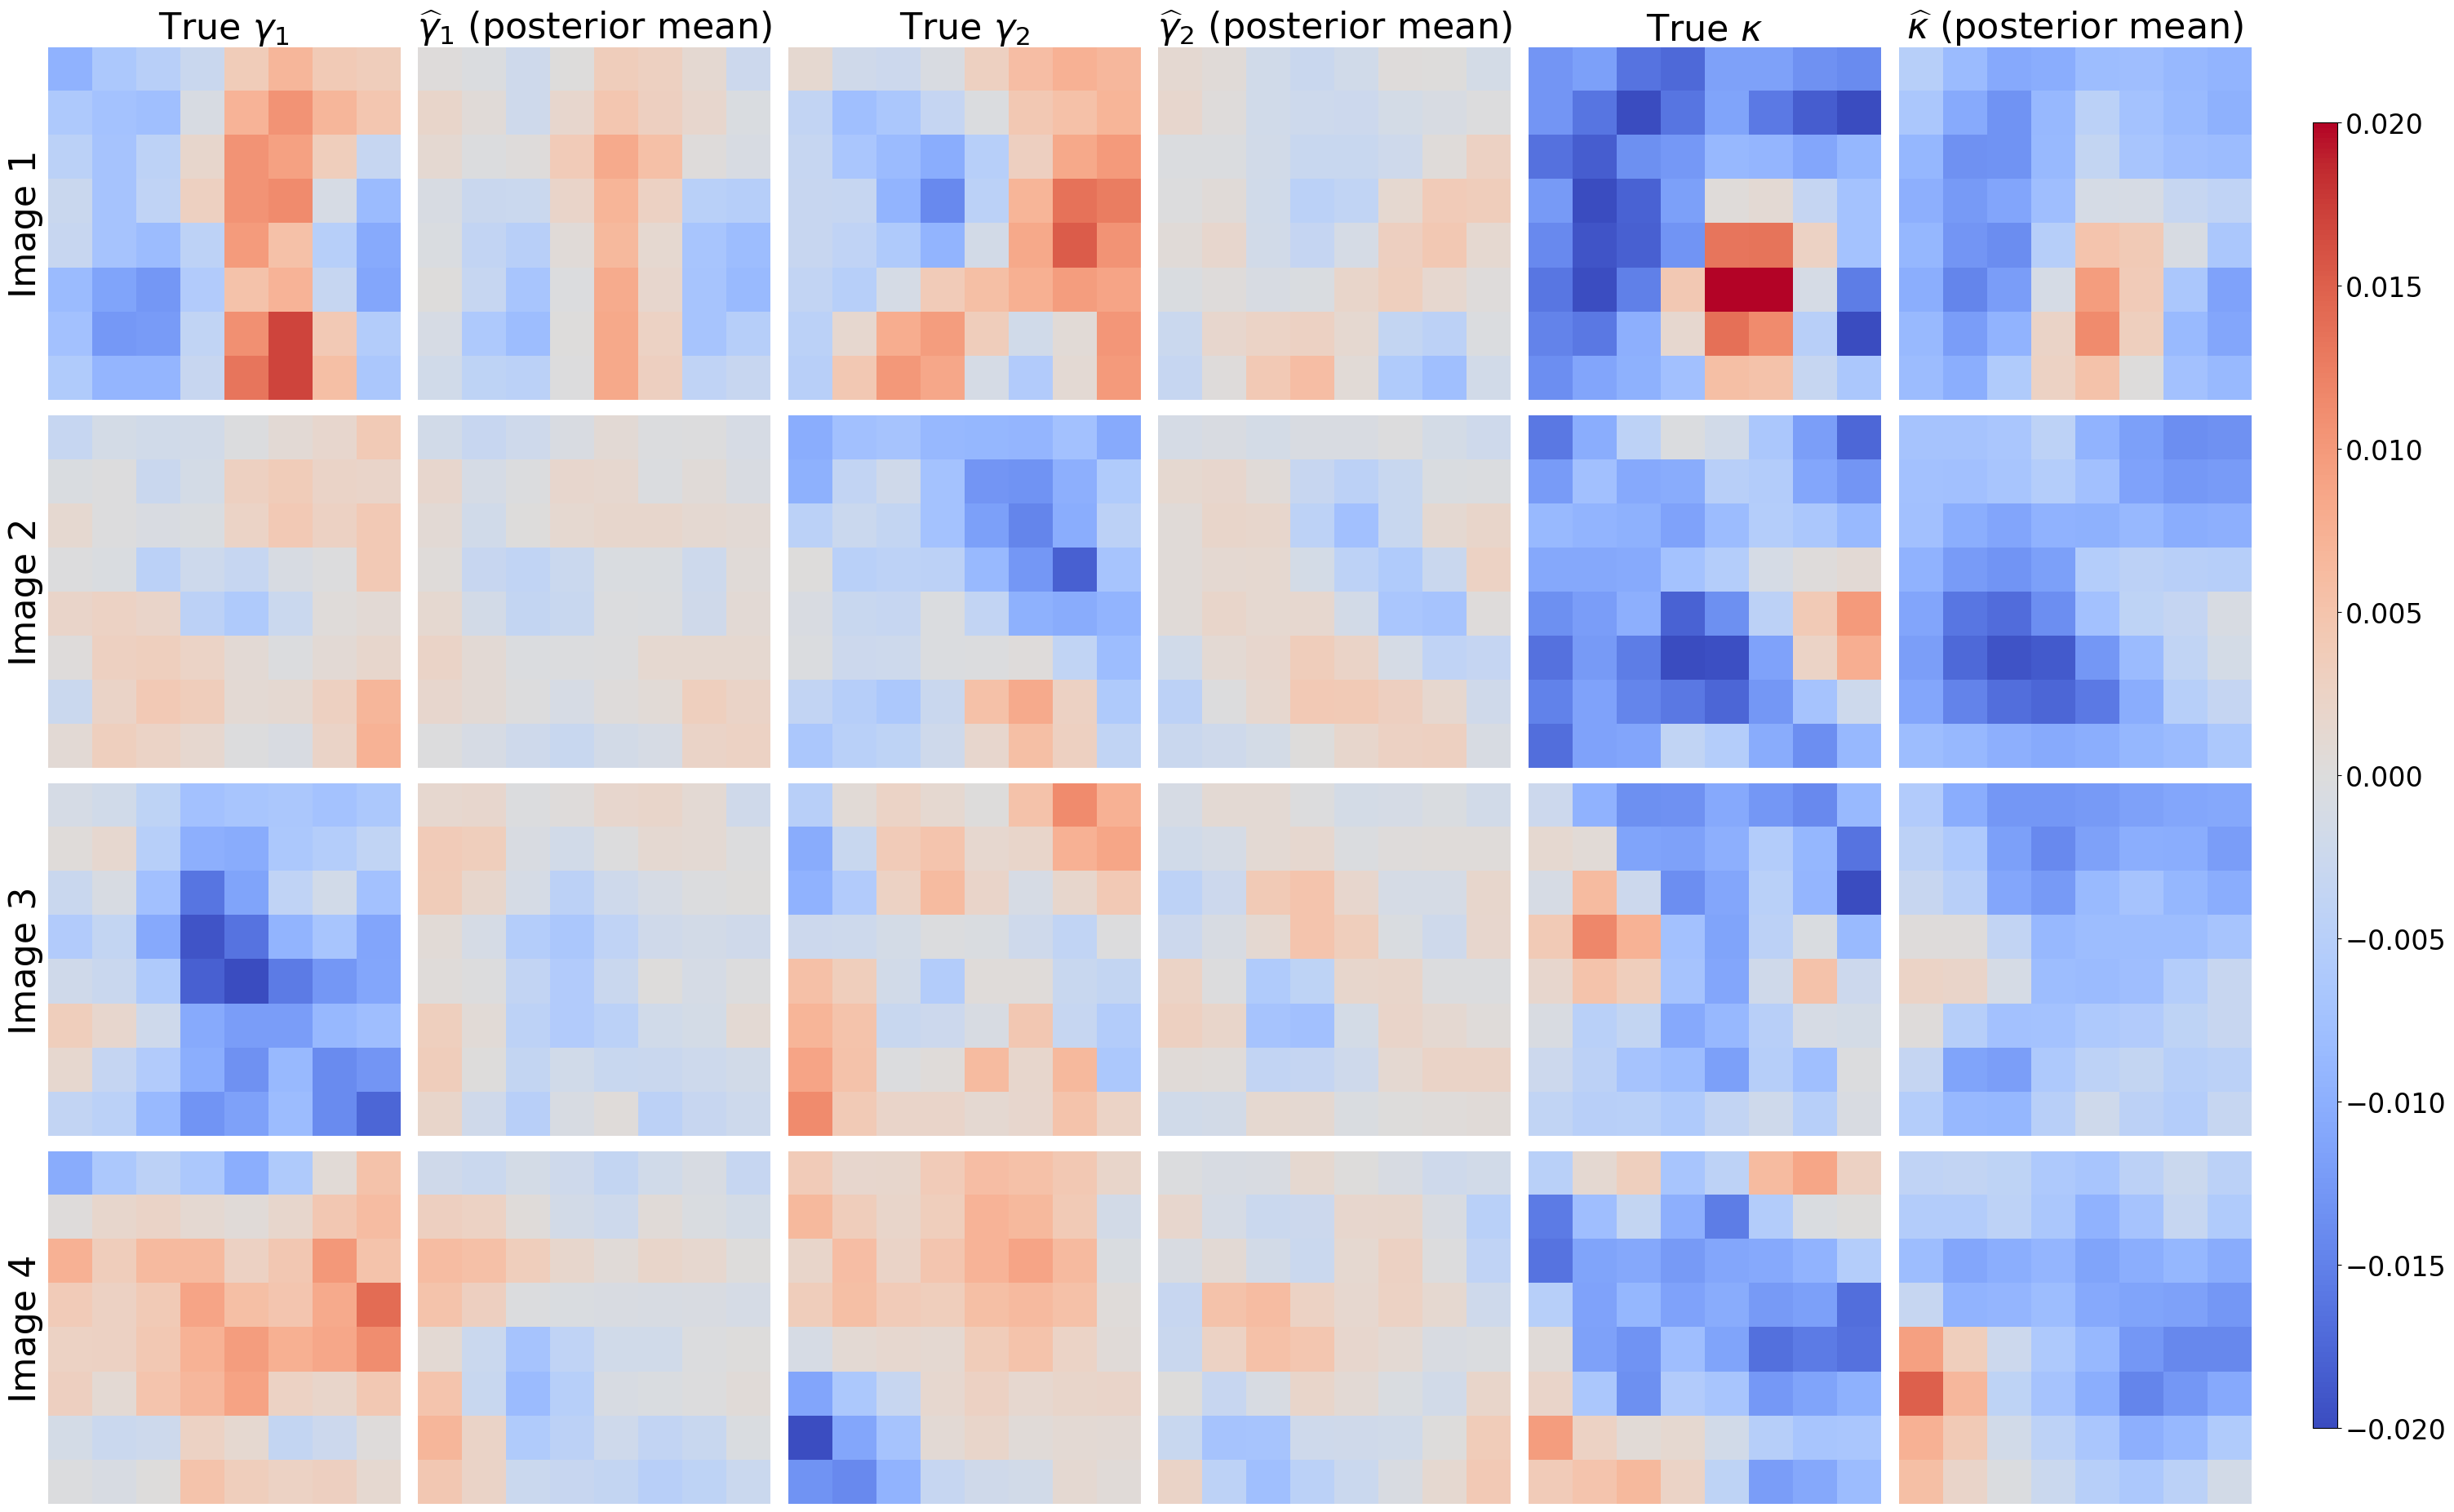

In [13]:
num_maps = 4
fig, ax = plt.subplots(num_maps, 6, figsize = (30,5*num_maps))
fontsize = 32
cmap = 'coolwarm'
vmin = -0.02
vmax = 0.02

for i in range(num_maps):
    _ = ax[i,0].imshow(shear1_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,0].set_title(r'True $\gamma_1$', fontsize = fontsize)
    _ = ax[i,0].set_xticks([])
    _ = ax[i,0].set_yticks([])
    _ = ax[i,0].set_ylabel(f'Image {i+1}', fontsize = fontsize)
    _ = ax[i,1].imshow(shear1_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,1].set_title(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,1].set_xticks([])
    _ = ax[i,1].set_yticks([])
    
    _ = ax[i,2].imshow(shear2_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,2].set_title(r'True $\gamma_2$', fontsize = fontsize)
    _ = ax[i,2].set_xticks([])
    _ = ax[i,2].set_yticks([])
    _ = ax[i,3].imshow(shear2_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,3].set_title(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,3].set_xticks([])
    _ = ax[i,3].set_yticks([])
    
    _ = ax[i,4].imshow(convergence_true[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,4].set_title(r'True $\kappa$', fontsize = fontsize)
    _ = ax[i,4].set_xticks([])
    _ = ax[i,4].set_yticks([])
    conv = ax[i,5].imshow(convergence_pred[i].cpu(), vmin = vmin, vmax = vmax, cmap = cmap)
    if i == 0:
        _ = ax[i,5].set_title(r'$\widehat{\kappa}$ (posterior mean)', fontsize = fontsize)
    _ = ax[i,5].set_xticks([])
    _ = ax[i,5].set_yticks([])

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.1, 0.01, 0.8])
cbar_ax.tick_params(labelsize = 0.75*fontsize)
fig.colorbar(conv, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.01)

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/figure5.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)